# Parte 1

## 1.1. Lectura de datos

#### Obtén de coindex los datos de al menos tres exchanges como ficheros CSV separados para al menos un período de un año.

In [127]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [128]:
coinbaseCSV = pd.read_csv('csv/coinbaseUSD.csv', sep=',', header=None, names = ['unixtime','price','amount'])
krakenCSV = pd.read_csv('csv/krakenUSD.csv', sep=',', header=None, names = ['unixtime','price','amount'])
localbtcCSV = pd.read_csv('csv/localbtcUSD.csv', sep=',', header=None, names = ['unixtime','price','amount'])

#coinbase = pd.read_csv('http://api.bitcoincharts.com/v1/trades.csv?symbol=coinbaseUSD', sep=',', header=None, names = ['unixtime','price','amount'])
#kraken = pd.read_csv('http://api.bitcoincharts.com/v1/trades.csv?symbol=krakenUSD', sep=',', header=None, names = ['unixtime','price','amount'])
#localbtc = pd.read_csv('http://api.bitcoincharts.com/v1/trades.csv?symbol=localbtcUSD', sep=',', header=None, names = ['unixtime','price','amount'])

Me quedo con los valores desde el 2015.

In [129]:
coinbaseCSV = coinbaseCSV[coinbaseCSV.unixtime>=1420070400]
krakenCSV = krakenCSV[krakenCSV.unixtime>=1420070400]
localbtcCSV = localbtcCSV[localbtcCSV.unixtime>=1420070400]

Indico a qué mercado corresponde cada valor.

In [130]:
coinbaseCSV['exchange'] = 'coinbase'
krakenCSV['exchange'] = 'kraken'
localbtcCSV['exchange'] = 'localbtc'

Me quedo con el último precio del día como precio de cierre del mercado.

In [131]:
#Cambiamos los unixtime a formato fecha y nos quedamos con el día.
coinbaseCSV['unixtime'] = coinbaseCSV['unixtime'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y/%m/%d'))
krakenCSV['unixtime'] = krakenCSV['unixtime'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y/%m/%d'))
localbtcCSV['unixtime'] = localbtcCSV['unixtime'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y/%m/%d'))

#Nos quedamos con el último precio de cada día
coinbaseCSV_close = coinbaseCSV.groupby('unixtime').last()
krakenCSV_close = krakenCSV.groupby('unixtime').last()
localbtcCSV_close = localbtcCSV.groupby('unixtime').last()

#Pasamos los índices a datetime
coinbaseCSV_close.index = pd.to_datetime(coinbaseCSV_close.index)
krakenCSV_close.index = pd.to_datetime(krakenCSV_close.index)
localbtcCSV_close.index = pd.to_datetime(localbtcCSV_close.index)

#### Carga los datos como un DataFrame fusionando los ficheros en uno solo.


In [132]:
frames = [coinbaseCSV_close, krakenCSV_close, localbtcCSV_close]
data = pd.concat(frames).sort_index()

Solo nos interesan las 2 primeras columnas del DataFrame.

In [133]:
data = data.drop('amount',1)

Comprobamos que ningún dato sea NaN

In [134]:
data.isnull().values.any()

False

## 1.3. Procesamiento

#### Obtén los días de máximo y mínimo valor de cotización.

In [136]:
print 'Día de máximo valor: ' + str(data['price'].idxmax())
print 'Día de mínimo valor: ' + str(data['price'].idxmin())

Día de máximo valor: 2016-02-19 00:00:00
Día de mínimo valor: 2015-01-14 00:00:00


#### Gráfico con la media móvil (“rolling mean”) simple de los valores de una de las series (puedes probar con varios valores de n). Nota: La media móvil puede encontrarse implementada en alguna biblioteca, no hace falta calcularla programando.

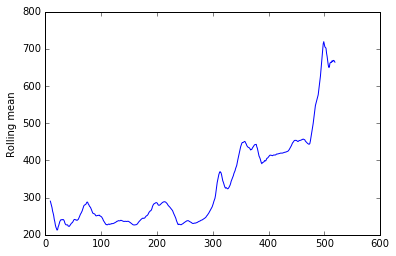

In [137]:
#Calculamos la media móvil
krakenRM = krakenCSV_close.reset_index()['price'].rolling(window=10).mean()

#Eliminamos los datos NaN
krakenRM.dropna(inplace=True)

#Utilizamos la GUI interna
%matplotlib inline

#Imprimimos el gráfico con la media móvil
plt.plot(krakenRM)
plt.ylabel('Rolling mean')
plt.show()

#### Obtén el máximo “spread” (diferencia para el mismo día en los diferentes exchanges) del precio de bitcoin, y el “spread medio” para todo el periodo.

In [138]:
#Unifico los precios por fecha
tmp = data.reset_index().groupby('unixtime')

#Calculo el spread de cada fecha
maxSpread = tmp['price'].max()
minSpread = tmp['price'].min()
spreads = maxSpread - minSpread

#Máximo spread
print 'Día de máximo spread: ' + str(spreads.idxmax()) + '. Máximo spread: ' + str(spreads.max())

Día de máximo spread: 2016-02-19 00:00:00. Máximo spread: 1176.72


#### Crea gráficos que los comparen dos a dos, y que muestren con alguna indicación gráfica (por ejemplo, un punto de otro color) los días de mayor “spread”. Pista: puedes obtener un subconjunto del dataframe solo con estos días y dibujarlo como si fuese otra serie diferente.

Comparación entre coinbase y kraken.

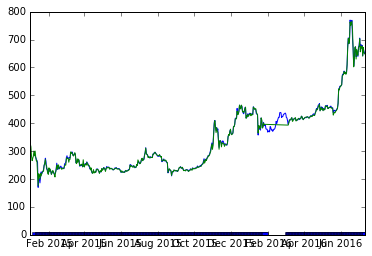

In [142]:
#Extraigo el spread entre los exchanges coinbase y kraken
comp1 = abs(coinbaseCSV_close['price'] - krakenCSV_close['price']).dropna().reset_index().groupby('unixtime')
maxComp1 = comp1['price'].max()
minComp1 = comp1['price'].min()
spreadComp1 = maxComp1 - minComp1

#Creo el gráfico que compara los 2 exchanges
plt.plot(coinbaseCSV_close['price'])
plt.plot(krakenCSV_close['price'])
#Introduzco la línea de spreads, pero no consigo que marque el día con mayor spread
plt.plot(spreadComp1, 'bs')
plt.show()

Comparación entre coinbase y localbtc.

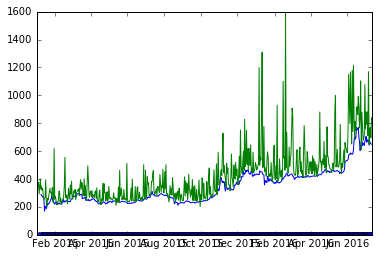

In [145]:
#Extraigo el spread entre los exchanges coinbase y localbtc
comp2 = abs(coinbaseCSV_close['price'] - localbtcCSV_close['price']).dropna().reset_index().groupby('unixtime')
maxComp2 = comp2['price'].max()
minComp2 = comp2['price'].min()
spreadComp2 = maxComp2 - minComp2

#Creo el gráfico que compara los 2 exchanges
plt.plot(coinbaseCSV_close['price'])
plt.plot(localbtcCSV_close['price'])
#Introduzco la línea de spreads, pero no consigo que marque el día con mayor spread
plt.plot(spreadComp2, 'bs')
plt.show()

Comparación entre kraken y localbtc.

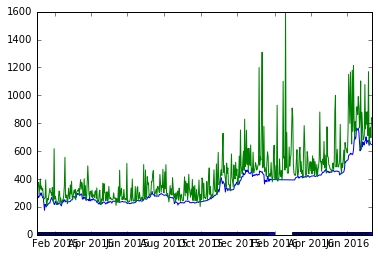

In [147]:
#Extraigo el spread entre los exchanges kraken y localbtc
comp3 = abs(krakenCSV_close['price'] - localbtcCSV_close['price']).dropna().reset_index().groupby('unixtime')
maxComp3 = comp3['price'].max()
minComp3 = comp3['price'].min()
spreadComp3 = maxComp3 - minComp3

#Creo el gráfico que compara los 2 exchanges
plt.plot(krakenCSV_close['price'])
plt.plot(localbtcCSV_close['price'])
#Introduzco la línea de spreads, pero no consigo que marque el día con mayor spread
plt.plot(spreadComp3, 'bs')
plt.show()